# **Structured Task**

In [1]:
# imports
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from scipy.stats import f
from copy import deepcopy
import gensim.downloader
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import scipy
import math

## Section 1

### Preparations

In [2]:
# Download and extract data and learn_decoder.py
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip

from learn_decoder import *

In [ ]:
# get data and concepts
data = read_matrix("imaging_data.csv", sep=",")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U'))

In [ ]:
# get GloVe embbedings
GloVe_vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")

In [ ]:
# get Word2Vec embedding model
Word2Vec_embedding = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
# get Word2Vec embeddings
Word2Vec_vectors = []
for c in concepts:

  # the embedding model does not contain the word 'argumentatively'
  # thus, we'll change it to 'argumentative' (approved via email)
  if c == "argumentatively":
    c = "argumentative"

  Word2Vec_vectors.append(Word2Vec_embedding[c])

Word2Vec_vectors = np.array(Word2Vec_vectors)

### Evaluating the Models

In [3]:
# constants
ITEM, VALUE = 0, 1

# functions from Pset 3, question 3
def cosine_similarity(v1, v2):
  return (v1 @ v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


def find_rank(v_hat, v, vectors):
  vectors_sorted = sorted(vectors, key=lambda u: cosine_similarity(u, v_hat), reverse=True)

  for i, u in enumerate(vectors_sorted):
    if np.array_equal(u, v):
      return i+1


def evaluate_fold(M, fold_data, fold_vectors, fold_concepts, vectors, fold_rank_dict, concept_rank_dict, i):
  rank_sum = 0

  for data, v, concept in zip(fold_data, fold_vectors, fold_concepts):
    v_hat = data @ M

    rank = find_rank(v_hat, v, vectors)
    concept_rank_dict[concept] = rank

    rank_sum += rank

  avg_rank = rank_sum / len(fold_concepts)
  fold_rank_dict[i] = avg_rank


def get_folds(dataset, i, fold_size):
  train_folds = np.concatenate((dataset[ : (i-1)*fold_size], dataset[i*fold_size : ]))
  test_fold = dataset[(i-1)*fold_size : i*fold_size]

  return train_folds, test_fold


def eval_model(data, vectors, concepts, fold_num):
  fold_rank_dict, concept_rank_dict = {}, {}
  fold_size = int(len(data) / fold_num)

  for i in range(1, fold_num + 1):
    train_data, test_data = get_folds(data, i, fold_size)
    train_vectors, test_vectors = get_folds(vectors, i, fold_size)
    train_concepts, test_concepts = get_folds(concepts, i, fold_size)

    M = learn_decoder(train_data, train_vectors)

    evaluate_fold(M, test_data, test_vectors, test_concepts, vectors, fold_rank_dict, concept_rank_dict, i)

  return fold_rank_dict, concept_rank_dict

# setting plot style
plt.style.use("ggplot")

# auxiliary functions we will use in this part
def display_desc_stats(rank_dict, model_name, item):
  sorted_rank = sorted([(item, value) for item, value in rank_dict.items()], key=lambda x: x[VALUE])
  median_idx = math.floor((len(sorted_rank) + 1) / 2)

  mean_score = sum(rank_dict.values()) / len(rank_dict.keys())
  median_score = sorted_rank[median_idx][1]

  print(f"--- {model_name} descriptive stats ---")
  print(f"Mean accuracy score for all {item + 's'}: {mean_score:.3f}")
  print(f"Median accuracy score for all {item + 's'}: {median_score:.3f}")

  # information only relevent for folds
  if item == "fold":
    min_fold, min_fold_rank = sorted_rank[0][ITEM], sorted_rank[0][VALUE]
    max_fold, max_fold_rank = sorted_rank[len(sorted_rank)-1][ITEM], sorted_rank[len(sorted_rank)-1][VALUE]

    print(f"\nLowest (best) score: {min_fold_rank:.3f}, for {item}: '{min_fold}'")
    print(f"Highest (worst) score: {max_fold_rank:.3f}, for {item}: '{max_fold}'")


def display_barplot(fold_rank_dict, model_name):
  x_vals, y_vals = list(fold_rank_dict.keys()), list(fold_rank_dict.values())

  # create bar plot with average score for each fold
  plt.bar(x_vals, y_vals, color='royalblue')

  plt.title(f"Average Accuracy Score for each Fold ({model_name})")
  plt.xlabel("fold")
  plt.ylabel("avg. accuracy score")

  # horizontal line represents the mean score
  fold_num = len(fold_rank_dict.keys())
  mean_score = sum(fold_rank_dict.values()) / fold_num

  plt.axhline(y = mean_score, color = 'red', linestyle = '--', label="mean")
  plt.xticks([i for i in range(1, fold_num + 1)])
  plt.legend()

  plt.show()


def show_success(rank_dict, threshold, model_name, items):
  less_success, more_success = [], []

  for key, score in rank_dict.items():
    if score < threshold:
      more_success.append(key)

    else:
      less_success.append(key)

  print(f"--- {model_name} ---")
  print(f'{items.capitalize()} "with more success" (a total of {len(more_success)} {items}):')
  print(f"{more_success}\n")

  print(f'{items.capitalize()} "with less success" (a total of {len(less_success)} {items}):')
  print(f"{less_success}\n")

  sorted_items = sorted(
    [(key, score) for key, score in rank_dict.items()],
    key=lambda x: x[1])

  sorted_items = [(x[0], np.round(x[1], 3)) for x in sorted_items]

  print(f"Top 5 most successfully decoded {items}:")
  print(sorted_items[:5])

  print(f"\nTop 5 least successfully decoded {items}:")
  print(sorted_items[-5:])



First, will calculate the accuracy score for the model using the GloVe embedding model.

In [ ]:
GloVe_fold_rank_dict, GloVe_concept_rank_dict = eval_model(data, GloVe_vectors, concepts, fold_num=18)

Second, will calculate the accuracy score for the model using the Word2Vec embedding model.

In [ ]:
Word2Vec_fold_rank_dict, Word2Vec_concept_rank_dict = eval_model(data, Word2Vec_vectors, concepts, fold_num=18)

Now, after calcuating the accuracy scores of both models, we will analyze the results and compare the two.

(*) Note that since the data contains 180 concepts, the accuracy score range is 1 (best) - 180 (worst). Moreover, this means that the expected accuracy score of a random classifier is 90.

In [ ]:
display_desc_stats(GloVe_fold_rank_dict, model_name= "GloVe model", item="fold")

--- GloVe model descriptive stats ---
Mean accuracy score for all folds: 61.911
Median accuracy score for all folds: 65.600

Lowest (best) score: 36.800, for fold: '16'
Highest (worst) score: 105.100, for fold: '9'


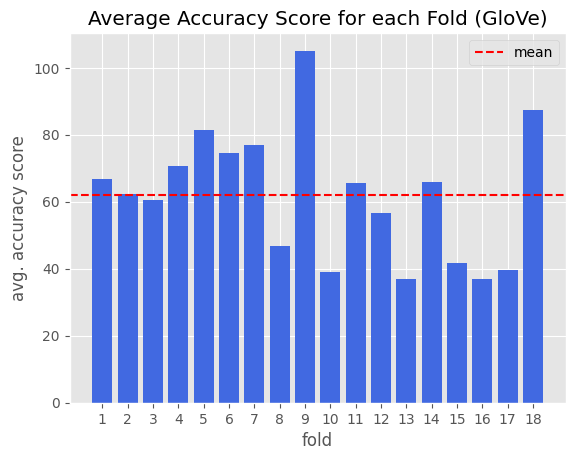

In [ ]:
display_barplot(GloVe_fold_rank_dict, model_name="GloVe")

In [ ]:
display_desc_stats(Word2Vec_fold_rank_dict, model_name="Word2Vec model", item="fold")

--- Word2Vec model descriptive stats ---
Mean accuracy score for all folds: 60.583
Median accuracy score for all folds: 60.500

Lowest (best) score: 36.500, for fold: '15'
Highest (worst) score: 84.000, for fold: '3'


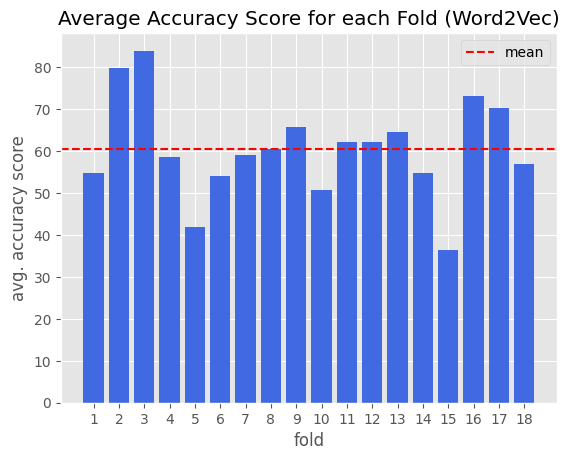

In [ ]:
display_barplot(Word2Vec_fold_rank_dict, model_name="Word2Vec")



As we can see, the mean and median accuracy scores of both models are much better (lower) than the expected accuracy score of a random classifier (90). Thus, we can conclude that both possess a significant amount of predictive power.

Moreover, from the results above, we can conclude the following:

* The Word2Vec model has a slightly better (lower) mean accuracy score than the GloVe model (60.58 compared to 61.91).
* The Word2Vec model has also a slightly better (lower) median accuracy score than the GloVe model (60.50 compared to 65.60).
* The Word2Vec best fold score is slightly better (lower) than the GloVe model (36.5 compared to 36.8).
* The Word2Vec worst fold score is significantly better (lower) than the GloVe model (84.0 compared to 105.1).

Thus, it appears that the Word2Vec model performed better in every measure mentioned. Therefore, the model’s overall performance is better when using the Word2Vec embeddings model.





In addition, let us compare the concepts that each model can predict with more/less success.

First, notice that the expected accuracy score of a random classifier is 90 for each concept (since there are 180 concepts). We will define that our model is considered to decode a concept "with more success" if its accuracy score on the concept is strictly less than 90 (strictly better than a random classifier). We consider the accuracy score 90 on a concept to be "with less success" since a simple random classifier (that requires no training at all) can perform just as good.

In [ ]:
concepts_num = len(concepts)
show_success(GloVe_concept_rank_dict, threshold=(concepts_num / 2), model_name="GloVe model", items="concepts")

--- GloVe model ---
Concepts "with more success" (a total of 134 concepts):
['ability', 'accomplished', 'angry', 'apartment', 'argument', 'art', 'attitude', 'bag', 'bar', 'bear', 'beat', 'beer', 'big', 'bird', 'blood', 'body', 'brain', 'broken', 'building', 'business', 'carefully', 'challenge', 'charming', 'code', 'collection', 'computer', 'construction', 'cook', 'crazy', 'damage', 'dance', 'dangerous', 'delivery', 'device', 'dig', 'dinner', 'disease', 'do', 'doctor', 'dog', 'dressing', 'economy', 'election', 'emotion', 'event', 'experiment', 'extremely', 'feeling', 'fight', 'fish', 'flow', 'food', 'gold', 'great', 'hair', 'help', 'hurting', 'impress', 'investigation', 'job', 'lady', 'land', 'laugh', 'law', 'left', 'level', 'light', 'magic', 'marriage', 'material', 'mechanism', 'medication', 'money', 'mountain', 'movement', 'music', 'nation', 'news', 'pain', 'personality', 'philosophy', 'picture', 'pig', 'plan', 'plant', 'play', 'pleasure', 'poor', 'professional', 'protection', 'qualit

In [ ]:
show_success(Word2Vec_concept_rank_dict, threshold=(concepts_num / 2), model_name="Word2Vec", items="concepts ")

--- Word2Vec ---
Concepts  "with more success" (a total of 135 concepts ):
['ability', 'angry', 'apartment', 'argumentatively', 'art', 'attitude', 'bag', 'ball', 'beer', 'big', 'bird', 'blood', 'brain', 'building', 'business', 'carefully', 'charming', 'clothes', 'cockroach', 'code', 'computer', 'cook', 'crazy', 'damage', 'dance', 'dangerous', 'deceive', 'dedication', 'deliberately', 'delivery', 'dessert', 'device', 'dig', 'dinner', 'disease', 'disturb', 'do', 'doctor', 'dog', 'dressing', 'economy', 'election', 'electron', 'elegance', 'emotion', 'emotionally', 'event', 'experiment', 'feeling', 'fight', 'fish', 'food', 'garbage', 'great', 'gun', 'hair', 'hurting', 'ignorance', 'illness', 'impress', 'invention', 'investigation', 'invisible', 'kindness', 'king', 'lady', 'laugh', 'law', 'left', 'liar', 'light', 'magic', 'marriage', 'material', 'mathematical', 'medication', 'money', 'mountain', 'movement', 'music', 'nation', 'obligation', 'pain', 'personality', 'philosophy', 'picture', 'pig'

From the above information, we can conclude the following:

* The Word2Vec model successufully decodes more concepts than the GloVe model by one (135 compared to 134).
*   The top 5 most successfully decoded concepts are completely different (expect from 'laugh') between the two models.
*   The top 5 least successfully decoded concepts are completely different between the two models.

These findings further emphasize the influence of the word embedding model on the decoder’s behavior.




## Section 2

In this section, we will discuss the similarities and differences between experiments 1, 2 and 3, conducted in "Pereira et al., 2018".



### Similarities

1. All experiments collected fMRI data received by exposing the subjects to stimuli (concepts or sentences).

2. All experiments evaluate the performance of the suggested decoder which predicts what stimulus the subject was exposed to, given their fMRI data.

3. All experiments used the GloVe word embedding model.

4. In all experiments, all participants are fluent English speakers.

5. The number of topics that were used in both experiments 2 and 3 is identical (24 topics in each). Moreover, in each experiment the topics are broad.


### Differences

1. The number of subjects in experiments 1, 2 and 3 is 16, 8 and 6 respectively.

2. In experiment 1, the stimuli presented to the subjects are concepts. In experiment 2 and 3, the stimuli presented to the subjects are sentences.

3. In experiment 1, each concept was presented using 3 paradigms (which were shown 4 to 6 times each):
  - "The target word was presented in the context of a sentence that made the relevant meaning salient".
  - "The target word was presented with a picture that depicted some aspect(s) of the relevant meaning".
  - "The target word was presented in a 'cloud', surrounded by five representative words from the cluster".

  However, in both experiments 2 and 3, for each passage, the sentences which are associated with that passage were shown to the subject one by one, and a total of 3 times. Moreover, each sentence was presented to the subject for the duration of 4 seconds (each time).

4. In all 3 experiments the model was trained on fMRI data received from a concept stimulation. However, in experiment 1, the trained model tries to predict concepts, while in experiments 2 and 3 the trained model tries to predict sentences.

5. In experiments 2 and 3, the decoder model was trained on all of the collected data from experiment 1 (fMRI data received when stimulating a subject with a concept). However, in experiment 1, this is not the case since cross-validation was performed (so the entire data was never used all at once as a training set).

6. Experiment 2 used 96 passages, each consisting of 4 sentences. On the other hand, experiment 3 used 72 passages, each consisting of 3-4 sentences.

7. The topics that were used in experiments 2 and 3 are different. Moreover, in experiment 2 each topic expressed by 4 passages, but only by 3 passages in experiment 3.


## Section 3

### Preparations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# auxiliary functions we will use in this part
def extract_train_data(path):
  df = pd.read_csv(path)
  df.drop(columns=df.columns[0], axis=1, inplace=True)
  data = df.to_numpy()
  return data


def extract_vectors(path):
  with open(path, 'r') as f:
    lst = f.readlines()
    lst = [x.split("\n")[0] for x in lst]

  vectors = np.array([np.array(x.split(' ')[:-1], dtype=float) for x in lst])
  return vectors


def extract_sentences(path):
  with open(path, 'r') as f:
    lst = f.readlines()

  sentences = [x.split('.')[0] for x in lst]
  return sentences


def unpickle(path):
  with open(path, 'rb') as f:
    exp_dict = pickle.load(f)

  return exp_dict


def eval_test_set(M, data, vectors, sentences):
  sentence_rank_dict = {}
  vectors_hat = data @ M

  for v, v_hat, s in zip(vectors, vectors_hat, sentences):
    rank = find_rank(v_hat, v, vectors)
    sentence_rank_dict[s] = rank

  return sentence_rank_dict

In [ ]:
train_data = extract_train_data("/content/drive/MyDrive/LaCC Project/Experiments 2 and 3 Data (For Structured & Semi-Structured Tasks)/neuralData_for_EXP1.csv")
train_vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")

# train the model according to the data of experiment 1
M = learn_decoder(train_data, train_vectors)

### Experiment 2 Accuracy Score Analysis


First, we will calculate the accuracy score of the trained model on the dataset of experiment 2.

In [ ]:
exp2_dict = unpickle("/content/drive/MyDrive/LaCC Project/Experiments 2 and 3 Data (For Structured & Semi-Structured Tasks)/EXP2.pkl")

data_2 = exp2_dict["Fmridata"]
vectors_2 = extract_vectors("/content/drive/MyDrive/LaCC Project/Experiments 2 and 3 Data (For Structured & Semi-Structured Tasks)/vectors_384sentences.GV42B300.average.txt")
sentences_2 = extract_sentences("/content/drive/MyDrive/LaCC Project/Experiments 2 and 3 Data (For Structured & Semi-Structured Tasks)/stimuli_384sentences.txt")

exp2_sentence_rank_dict = eval_test_set(M, data_2, vectors_2, sentences_2)

Now, we will analyze the accuracy score results.

(*) Note that since the data contains 384 sentences, the accuracy score range is 1 (best) - 384 (worst). Moreover, this means that the expected accuracy score of a random classifier is 192.

In [ ]:
display_desc_stats(exp2_sentence_rank_dict, model_name="Experminet 2", item="sentence")

--- Experminet 2 descriptive stats ---
Mean accuracy score for all sentences: 156.927
Median accuracy score for all sentences: 136.000


As we can see, the mean and median accuracy scores of our trained model are 156.927 and 136.0 respectively.

Notice that these scores are much better (lower) than the ones of a random classifier (192).

Moreover, let us find the sentences (from experiment 2) that our trained model can predict with more/less success.

We will label the sentences based on the same principle discussed in the first section. Since the number of sentences is 384, our threshold for a succesful decoding is 192 (non-inclusive).

In [ ]:
threshold = len(sentences_2) / 2
show_success(exp2_sentence_rank_dict, threshold, model_name="Experiment 2", items="sentences")

--- Experiment 2 ---
Sentences "with more success" (a total of 244 sentences):
['An apartment is a self-contained home that is part of a building', 'An apartment may have one or more rooms, as well as a kitchen and a bathroom', 'Some apartments are for single people, others for families', 'An apple is a fruit that can be green, red or yellow', 'Apples have thin skin, a crisp, sweet pulp and seeds inside', 'Arson can be done to cause damage to others or collect insurance', 'The severity of the crime depends on whether people were harmed', 'A car can be powered by a gasoline or electric engine', 'Automobiles vary in size, number of doors and the type of trunk', 'The axe usually consists of a head attached to a handle', 'Historically, axe heads were made of stone and then metal', 'A banana is a long fruit that grows in bunchs, with a soft edible inside', 'A banana when ripe can be yellow, purple or red and have small brown spots', 'The greatest producers are tropical countries, such as In

As we can see, 244 sentences (63.5%) were decoded with more success.

Thus, the majority of the sentences are decoded successfully with our model.

### Experiment 3 Accuracy Score Analysis

First, we will calculate the accuracy score of the trained model on the dataset of experiment 3.

In [ ]:
exp3_dict = unpickle("/content/drive/MyDrive/LaCC Project/Experiments 2 and 3 Data (For Structured & Semi-Structured Tasks)/EXP3.pkl")

data_3 = exp3_dict["Fmridata"]
vectors_3 = extract_vectors("/content/drive/MyDrive/LaCC Project/Experiments 2 and 3 Data (For Structured & Semi-Structured Tasks)/vectors_243sentences.GV42B300.average.txt")
sentences_3 = extract_sentences("/content/drive/MyDrive/LaCC Project/Experiments 2 and 3 Data (For Structured & Semi-Structured Tasks)/stimuli_243sentences.txt")

exp3_sentence_rank_dict = eval_test_set(M, data_3, vectors_3, sentences_3)

Now, we will analyze the accuracy score results.

(*) Note that since the data contains 243 sentences, the accuracy score range is 1 (best) - 243 (worst). Moreover, this means that the expected accuracy score of a random classifier is now 121.5.



In [ ]:
display_desc_stats(exp3_sentence_rank_dict, model_name="Experiment 3", item="sentence")

--- Experiment 3 descriptive stats ---
Mean accuracy score for all sentences: 100.745
Median accuracy score for all sentences: 87.000


As we can see, the mean and median accuracy scores of our trained model are 100.745 and 87.0 respectively.

Notice that these scores are much better (lower) than the ones of a random classifier (121.5).

Moreover, let us find the sentences (from experiment 3) that our trained model can predict with more/less success.

We will label the sentences based on the same principle discussed in the first section. Since the number of sentences is 243, our threshold for a successful decoding is 121.5 (non-including).



In [ ]:
threshold = len(sentences_2) / 2
show_success(exp3_sentence_rank_dict, threshold, model_name="Experiment 3", items="sentences")

--- Experiment 3 ---
Sentences "with more success" (a total of 203 sentences):
['As a passive form of agriculture, it does not require that native vegetation be cleared to make way for crops', 'Artisanal beekeepers go to extremes for their craft, but their product is worth the effort', 'They scout the fields, know when nectar flows, and select the best ways to extract honey', "Bees crawl across his bare arms and hands, but they don't sting, because they're gentle", "I have a recurring dream about exams, even though I'm no longer in college", "In my dream, it's the day of my final exam and I suddenly realize I've never gone to class", "I've never even done any of the reading assignments", 'I know many other people who have the same nightmare', 'Each morning, participants in the study had to write down their dream experience from the previous night', 'They recorded if they recalled any dreams, and described each dream and its emotional intensity', 'Participants then assigned each dream t

As we can see, 203 sentences (83.5%) were decoded with more success.

Thus, the vast majority of the sentences are decoded successfully with our model.

### Discussing the Results

As we can see, our trained model performed much better than a random classifier in both experiments. Moreover, most of the sentences were decoded successfully with our model. Thus, our model possesses a significant amount of predictive power as attested by the mentioned metrics. This insight is very impressive given the fact that our model was trained on concepts and not sentences. For that same reason, it also implies excellent generalization capabilities.

## Section 4

In both experiments, each sentence is associated with a passage and each passage is associated with a topic. Thus, we will define that a sentence is associated with a topic if its passage is associated with the topic.

Now, we will define that a topic is “successful” if the average accuracy score of all the sentences associated with it is better (strictly lower) than a random classifier (the same principle discussed in the first section).

For each of the two experiments, we will find the number of successful topics.


In [ ]:
# constants
RANK, COUNT = 0, 1

# auxiliary functions we will use in this part
def calc_topic_rank_dict(sentence_rank_dict, topics, sentences_passages, passages_topics):
  topic_rank_dict = {}

  for i, rank in enumerate(sentence_rank_dict.values()):
    passage_idx = sentences_passages[i] - 1
    topic_idx = passages_topics[passage_idx] - 1
    topic = topics[topic_idx]

    if topic not in topic_rank_dict.keys():
      topic_rank_dict[topic] = [rank, 1]

    else:
      topic_rank_dict[topic][RANK] += rank
      topic_rank_dict[topic][COUNT] += 1

  # calculates the rank of each topic by the average rank of sentences associated with that topic
  for topic, value in topic_rank_dict.items():
    topic_rank_dict[topic] = value[RANK] / value[COUNT]

  return topic_rank_dict

### Experiment 2 Successful Topics


First, we will calculate the accuracy score of the trained model on each of the topics from experiment 2.


In [ ]:
# extract data from experiment 2 dictionary
exp2_topics = [x[0] for x in exp2_dict["keyPassageCategory"][0]]
exp2_sentences_passages = [x[0] for x in exp2_dict["labelsPassageForEachSentence"]]
exp2_passages_topics = [x[0] for x in exp2_dict["labelsPassageCategory"]]

# 'exp2_topics_rank_dict' is defined as follows:
# key - topic name
# value - average rank of all the sentences associated with that topic
exp2_topics_rank_dict = calc_topic_rank_dict(exp2_sentence_rank_dict, exp2_topics, exp2_sentences_passages, exp2_passages_topics)

Now, we will analyze the results and find the successful topics.

We will label these topics based on the same principle discussed in the first section. Since the number of sentences in experiment 2 is 384, our threshold for a successful topic is 192 (non-including).

In [ ]:
threshold = len(exp2_sentence_rank_dict.keys()) / 2
show_success(exp2_topics_rank_dict, threshold, model_name= "Experiment 2", items="topics")

--- Experiment 2 ---
Topics "with more success" (a total of 21 topics):
['music', 'dwelling', 'fruit', 'crime', 'vehicles_transport', 'weapon', 'furniture', 'insect', 'appliance', 'human', 'fish', 'drink_non_alcoholic', 'landscape', 'building_part', 'clothing', 'disaster', 'bird', 'body_part', 'place', 'kitchen_utensil', 'tool']

Topics "with less success" (a total of 3 topics):
['profession', 'vegetable', 'animal']

Top 5 most successfully decoded topics:
[('body_part', 70.438), ('human', 92.75), ('drink_non_alcoholic', 98.938), ('dwelling', 113.688), ('appliance', 113.75)]

Top 5 least successfully decoded topics:
[('music', 185.0), ('vehicles_transport', 186.688), ('animal', 196.25), ('vegetable', 237.625), ('profession', 249.125)]


From the results above, we can see which topics are considered successful or not (according to our labeling criteria).

Moreover, it appears that 21 topics (87.5%) are successful. Thus, the majority of the topics are considered successful using our model.

### Experiment 3 Successful Topics

First, we will calculate the accuracy score of the trained model on each of the topics from experiment 2.

In [ ]:
# extract data from experiment 3 dictionary
exp3_topics = [x[0] for x in exp3_dict["keyPassageCategory"][0]]
exp3_sentences_passages = [x[0] for x in exp3_dict["labelsPassageForEachSentence"]]
exp3_passages_topics = [x[0] for x in exp3_dict["labelsPassageCategory"]]

# 'exp3_topics_rank_dict' is defined as follows:
# key - topic name
# value - average rank of all the sentences associated with that topic
exp3_topics_rank_dict = calc_topic_rank_dict(exp3_sentence_rank_dict, exp3_topics, exp3_sentences_passages, exp3_passages_topics)

Now, we will analyze the results and find the successful topics.

We will label these topics based on the same principle discussed in the first section. Since the number of sentences in experiment 3 is 243, our threshold for a successful topic is 121.5 (non-including).

In [ ]:
threshold = len(exp3_sentence_rank_dict.keys()) / 2
show_success(exp3_topics_rank_dict, threshold, model_name= "Experiment 3", items="topics")

--- Experiment 3 ---
Topics "with more success" (a total of 18 topics):
['dreams', 'gambling', 'hurricane', 'ice_cream', 'astronaut', 'computer_graphics', 'law_school', 'stress', 'tuxedo', 'blindness', 'taste', 'bone_fracture', 'infection', 'opera', 'painter', 'polar_bear', 'castle', 'rock_climbing']

Topics "with less success" (a total of 6 topics):
['beekeeping', 'lawn_mower', 'pharmacist', 'owl', 'pyramid', 'skiing']

Top 5 most successfully decoded topics:
[('dreams', 52.8), ('stress', 58.2), ('castle', 59.1), ('opera', 63.636), ('bone_fracture', 68.091)]

Top 5 least successfully decoded topics:
[('pharmacist', 136.6), ('pyramid', 147.2), ('lawn_mower', 148.1), ('owl', 148.6), ('beekeeping', 169.818)]


From the results above, we can see which topics are considered successful or not (according to our labeling criteria).

Moreover, it appears that 21 topics (87.5%) are successful. Thus, the majority of the topics are considered successful using our model.

### Discussing the Results

From the results above, in both experiments, most of the topics are considered successful using our model. This implies that even though our model was initially trained on concepts, it has a significant amount of predictive power on sentences from a broad range of topics. This insight is remarkable and furthermore supports our conclusion in the previous section regarding the model’s excellent generalization capabilities.

# **Semi-Structured Task**

## Section 1

In this section, we will assess our model performance under two different word embedding models:

*   GloVe model (as used in the paper).
*   BERT contextualized word embedding model.

We were asked to used either the data from experiment 2 or 3 for the assessment process. Notice that the data from experiment 2 contains more sentences than experiment 3 (384 compared to 243). Since using a larger dataset allows us to better understand the model’s capabilities and performance, we will chosse to use this data.

In order to assess the performance of each of the described models, we will performe cross-validation. This assessment method will allow us to gain an overall picture of our model’s performance, and thus project objective findings. In the cross-validation process we will use 16 folds - each containing 24 sentences.

(*) Note that since the data contains 384 sentences, the accuracy score range is 1 (best) - 384 (worst). Moreover, this means that the expected accuracy score of a random classifier is 192.

In [ ]:
exp2_dict = unpickle("/content/drive/MyDrive/LaCC Project/Experiments 2 and 3 Data (For Structured & Semi-Structured Tasks)/EXP2.pkl")

train_data = exp2_dict["Fmridata"]
train_sentences = extract_sentences("/content/drive/MyDrive/LaCC Project/Experiments 2 and 3 Data (For Structured & Semi-Structured Tasks)/stimuli_384sentences.txt")

### GloVe Model

First, we will train the decoder using the GloVe embedded vectors and perform the mentioned cross-validation.

In [ ]:
GloVe_train_vectors = extract_vectors("/content/drive/MyDrive/LaCC Project/Experiments 2 and 3 Data (For Structured & Semi-Structured Tasks)/vectors_384sentences.GV42B300.average.txt")

GloVe_fold_rank_dict, GloVe_sentence_rank_dict = eval_model(train_data, GloVe_train_vectors, train_sentences, fold_num=16)

Now, we will analyze the accuracy score results.

In [ ]:
display_desc_stats(GloVe_fold_rank_dict, model_name="GloVe model", item="fold")

--- GloVe model descriptive stats ---
Mean accuracy score for all folds: 137.326
Median accuracy score for all folds: 140.375

Lowest (best) score: 104.583, for fold: '6'
Highest (worst) score: 174.250, for fold: '13'


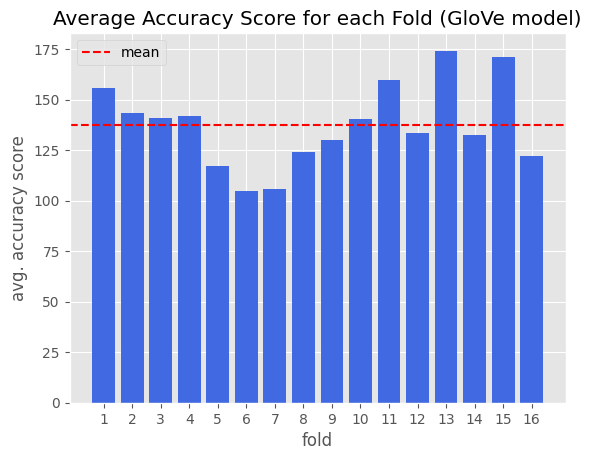

In [ ]:
display_barplot(GloVe_fold_rank_dict, model_name="GloVe model")

As we can see, both mean and median accuracy scores are much better (lower) than the expected accuracy score of a random classifier (192). In addition, it appears that even the model's worst fold has a lower accuracy score than the one of a random classifier.

Moreover, let us find the sentences that our trained model can predict with more/less success.

We will label the sentences based on the same principle discussed in the first section. Since the number of sentences is 384, our threshold for a successful decoding is 192 (non-inclusive).

In [ ]:
threshold = len(GloVe_sentence_rank_dict.keys()) / 2
show_success(GloVe_sentence_rank_dict, threshold, "GloVe model", "sentences")

--- GloVe model ---
Sentences "with more success" (a total of 274 sentences):
['One keyboard is used for individual notes, the other for chords', 'An apartment may have one or more rooms, as well as a kitchen and a bathroom', 'Some apartments are for single people, others for families', 'The building can have a garage, a laundry facility or extra storage space', 'An apple is a fruit that can be green, red or yellow', 'Apples have thin skin, a crisp, sweet pulp and seeds inside', 'Some very tart apples are used to make cider', 'Apples can be eaten raw, roasted or baked in pies', 'Arson can be done to cause damage to others or collect insurance', 'The severity of the crime depends on whether people were harmed', 'The driver steers the car on roads, other passengers just sit', 'Automobiles vary in size, number of doors and the type of trunk', 'The axe is a tool used to split and cut wood', 'The axe usually consists of a head attached to a handle', 'Historically, axe heads were made of sto

From the results above, we can see which sentences are considered successful or not (according to our labeling criteria).

It appears that 274 sentences (71.4%) are successful.

Thus, the majority of the sentences are considered successful using our model.

### BERT Model

First, we will initialize the pre-trained BERT model and create the embedded vectors for the sentences used in the experiment.

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

In [ ]:
BERT_train_vectors = model.encode(train_sentences)

Second, we will train the decoder using the BERT embedded vectors and perform the mentioned cross-validation.

In [ ]:
BERT_fold_rank_dict, BERT_sentence_rank_dict = eval_model(train_data, BERT_train_vectors, train_sentences, fold_num=16)

Now, we will analyze the accuracy score results.

In [ ]:
display_desc_stats(BERT_fold_rank_dict, model_name="BERT model", item="fold")

--- BERT model descriptive stats ---
Mean accuracy score for all folds: 118.081
Median accuracy score for all folds: 119.333

Lowest (best) score: 72.750, for fold: '14'
Highest (worst) score: 155.000, for fold: '5'


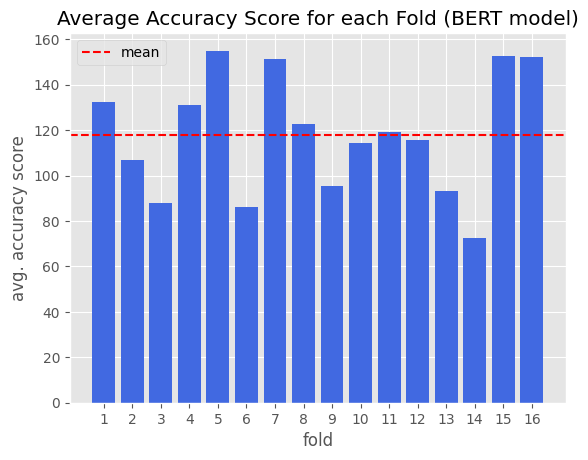

In [ ]:
display_barplot(BERT_fold_rank_dict, model_name="BERT model")

As we can see, both mean and median accuracy scores are lower than 121.5 (the expected accuracy score of a random classifier). In addition, it appears that even the model's worst fold has a lower accuracy score than the one of a random classifier.

Moreover, let us find the sentences that our trained model can predict with more/less success (the same way done previously).

In [ ]:
threshold = len(BERT_sentence_rank_dict.keys()) / 2
show_success(BERT_sentence_rank_dict, threshold, "BERT model", "sentences")

--- BERT model ---
Sentences "with more success" (a total of 301 sentences):
['An accordion is a portable musical instrument with two keyboards', 'One keyboard is used for individual notes, the other for chords', 'An apartment is a self-contained home that is part of a building', 'An apartment may have one or more rooms, as well as a kitchen and a bathroom', 'Some apartments are for single people, others for families', 'The building can have a garage, a laundry facility or extra storage space', 'An apple is a fruit that can be green, red or yellow', 'Apples have thin skin, a crisp, sweet pulp and seeds inside', 'Some very tart apples are used to make cider', 'Apples can be eaten raw, roasted or baked in pies', 'Arson can be done to cause damage to others or collect insurance', 'The severity of the crime depends on whether people were harmed', 'A car can be powered by a gasoline or electric engine', 'Automobiles vary in size, number of doors and the type of trunk', 'The axe is a tool us

From the results above, we can see which sentences are considered successful or not (according to our labeling criteria).

It appears that 301 sentences (78.4%) are successful.

Thus, the majority of the topics are considered successful using our model.

### Discussing the Results

As we can see, both models have excellent performance as attested by the measures mentioned above.

However, from the results above we can conclude the following:

* The mean accuracy score of the BERT model is significantly better (~15% lower) than the GloVe model.
* The medain accuracy score of the BERT model is significantly better (~15% lower) than the GloVe model.
* The accuracy score of the BERT model best fold is notably better than the one of the GloVe model (72.75 compared to 104.58).
* The accuracy score of the BERT model worst fold is better than the one of the GloVe model (155.0 compared to 174.25).

Thus, it appears that the BERT model performed significantly better in every measure mentioned.

Therefore, we can conclude that the BERT model has better overall performance than the GloVe model.

Moreover, we noticed that the top 5 most successfully decoded sentences are very different between the two models. The same insight goes for the top 5 least successfully decoded sentences as well. These results further highlight the influence of the word embedding model on the decoder’s behavior (as discussed in section 1 of the Structuerd Task).







## Section 2

In this section, we will fit a linear regression model for each of the voxels (a total of 185,866 voxels) using two different embedding models:

*   GloVe model (the embedding model used in the paper).
*   BERT model (the contextualized word embedding model we extracted in the previous section).

In order to achieve our goal, we will use the data related to experiment 2 (from the same reasons mentioned in the previous section).

In [ ]:
# auxiliary functions we will use in this part
def find_sum_squares(beta_hat, X, y):
  y_avg = np.mean(y)
  SSR, SSE = 0, 0
  for xi, yi in zip(X, y):
    y_hat = beta_hat.T @ xi
    SSR += (y_hat - y_avg) ** 2
    SSE += (y_hat - yi) ** 2

  SST = SSR + SSE

  return SSR, SSE, SST

def linear_reg(X, y, P):
  beta_hat = P @ y

  n, p = X.shape
  k = p - 1

  SSR, SSE, SST = find_sum_squares(beta_hat, X, y)
  SSR_df, SSE_df, SST_df = k, n-p, n-1

  MSR = SSR / SSR_df
  MSE = SSE / SSE_df
  MST = SST / SST_df

  F = MSR / MSE
  p_value = 1 - f.cdf(F, k, n-p)

  R_squared = SSR / SST

  return R_squared, p_value


def voxels_linear_reg(vectors, data):
  R_squared_lst, p_value_lst = [], []

  # add a bias column to the vectors matrix (X)
  bias_col = [[1] for i in range(len(vectors))]
  vectors = np.append(vectors, bias_col, axis=1)

  # find the P matrix associated for all voxels
  P = np.linalg.inv(vectors.T @ vectors) @ vectors.T

  for i in range(data.shape[1]):

    R_squared, p_value = linear_reg(X=vectors, y=data[:, i], P=P)

    R_squared_lst.append(R_squared)
    p_value_lst.append(p_value)

  return R_squared_lst, p_value_lst


def create_histogram(values, bins=10, model_name="GloVe"):
  sns.histplot(values, bins=bins, kde=True)

  plt.title(f"Histogram of R^2 for All Voxels ({model_name} Model)")
  plt.xlabel("R^2")
  plt.ylabel("count")

  plt.show()


def create_pie_chart(pvalues, model_name="GloVe"):
  labels = ["Significant", "Insignificant"]
  num_siginificant = sum([pv < 0.05 for pv in pvalues])
  vals = [num_siginificant, len(pvalues) - num_siginificant]

  plt.pie(vals, labels=labels, autopct='%1.1f%%')
  plt.title(f"Distribution of Significant Voxels ({model_name} Model)")
  plt.show()

### GloVe model

First, we will perform linear regression for each voxel (using the GloVe embedded vectors) and find the $R^2$ and $p_{value}$ values of each reggresion model.

In [ ]:
R_squared_GloVe, p_value_GloVe = voxels_linear_reg(GloVe_train_vectors, train_data)

Now, let us display the results:

*   Distribution of $R^2$ values across all voxels.
*   Percentage of significant associations of voxels activity with the embedded word vectors ($p_{value} < 0.05$).

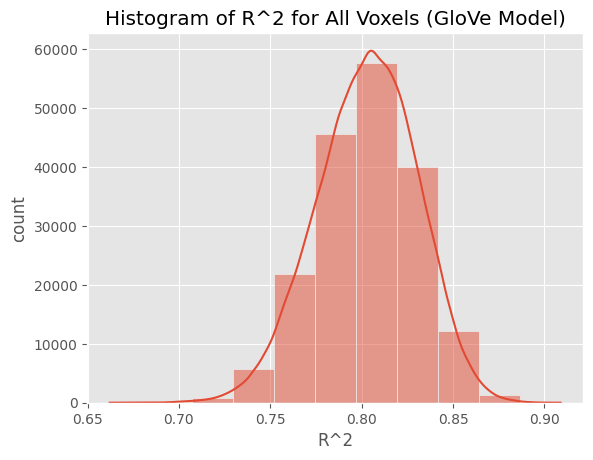

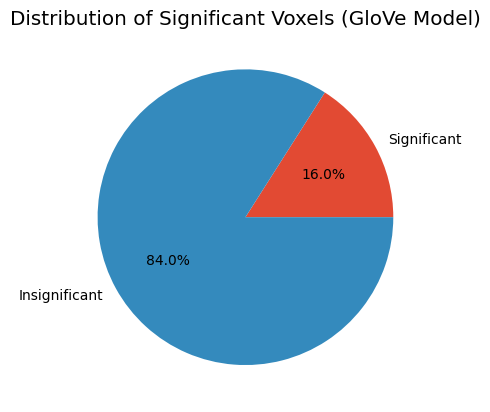

In [ ]:
create_histogram(R_squared_GloVe, bins=11, model_name="GloVe")

print()

create_pie_chart(p_value_GloVe, model_name="GloVe")

From the above results we can conclude the following:

* The most common $R^2$ value is around 0.8. Moreover, the distribution is symmetrical around this value. Thus, the distribution seems like the Normal distribution with $μ = 0.8$.
* The vast majority of the regression models are statistically insignificant (84.0%).



### BERT Model

Note that the BERT model embeds words into a 768-dimensional vector space, while we only have 384 sentences in experiment 2 (the experiment with the higher number of sentences between the two). Thus, we have more explaining variables than samples in our linear regression model. As a result, we cannot find the p-value of the model (as required in this section).

In order to overcome that, we will perform dimensionality reduction (using PCA) on the 768-dimensional embedded word vectors. We chose to reduce the embedded vectors to 300 dimensions (the same dimension as the GloVe model vectors), in order to be able to better compare the results of the two models.

First we will execute the above mentioned dimensionality reduction (using PCA).

In [ ]:
pca_to300 = PCA(n_components=300, svd_solver="full")
BERT_300d_vectors = pca_to300.fit_transform(BERT_train_vectors)

Now, we can perform linear regression for each voxel (using the BERT reduced 300-dimensions embedded vectors) and find the values $R^2$ and $p_{value}$ of each reggresion model.


In [ ]:
R_squared_BERT, p_value_BERT = voxels_linear_reg(BERT_300d_vectors, train_data)

Let us display the results:

*   Distribution of $R^2$ values across all voxels.
*   Percentage of significant associations of voxels activity with the embedded word vectors ($p_{value} < 0.05$).

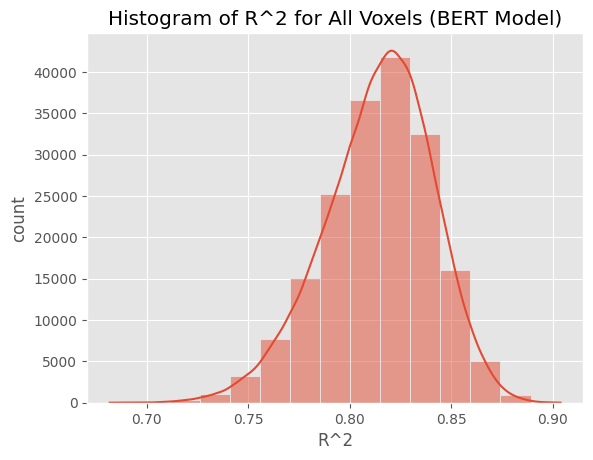

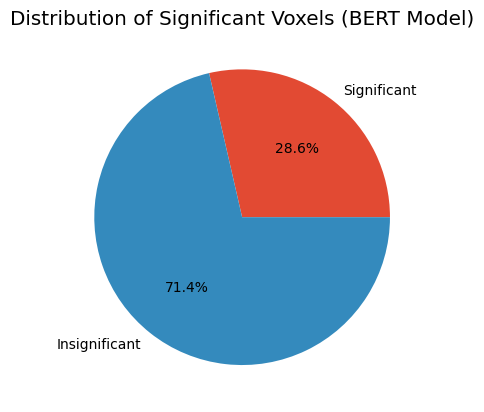

In [ ]:
create_histogram(R_squared_BERT, bins=15, model_name="BERT")

print()

create_pie_chart(p_value_BERT, model_name="BERT")

From the above results we can conculde the following:

* The most common $R^2$ value is around 0.8. Moreover, the distribution is symmetrical around this value. Thus, the distribution seems like the Normal distribution with $μ = 0.8$.
* The vast majority of regression models are statistically insignificant (71.4%).



### Discussing the Results

First, although we used different embedding models, the distributions of $R^2$ values are approximately the same between the two (Normal distribution with $\mu = 0.8$).

Second, in both models, the vast majority of the voxel regression models is insignificant. However, the BERT embedding model is much better (28.6% significant compared to 16%).


# **Open-ended Task**

In the previous tasks, the analysis was done using only fMRI data from an individual subject. As a natural extension to our prior research, we would now like to perform an analysis using data from multiple subjects. After discussing this idea with a course staff member, we were advised to use the dataset from the paper “Pereira et al., 2018” (the paper Project 2 is based on). This dataset contains brain data sampled from 16 subjects who took part in various experiments (experiments 1-3 as described in the paper).

Our open-ended task will be divided into two main analyses: one will focus on the brain decoder, and the other on the brain encoder (as seen in the previous tasks).

As mentioned at the beginning, not all 16 subjects took part in all three experiments. However, all subjects participated in experiment 1. Therefore, in this task we will focuse on data exclusively from that experiment, to gain the highest possible number of subjects we could perform the analysis on. In addition, throughout the analysis we will use the GloVe word embedding model (as done in the paper).



## Prepering the Data

The analysis that will be done in this part will require an equal number of voxels for each of the subjects (for example, it will involve training a model on one subject and evaluating its performance on different subjects). However, this is not the case in our data. Therefore, we cannot use voxels fMRI data for our analysis. On the other hand, we noticed that the number of ROIs (Region of Interest) in all subjects’ data is the same (116). Moreover, each subject’s data specifies the voxels that compose each ROI. Thus, we will choose to use ROIs fMRI data (instead of voxels fMRI data), in order to satisfy the mentioned requirement of the analysis.

The ROIs fMRI data (for each of the subjects) was extracted as follows:

The raw data of a subject contains voxels fMRI data for each of the three paradigms described in the paper. To attain experiment 1’s overall voxels fMRI data which considers all three paradigms, we averaged the voxels data across all three of them (as done in the paper). Then, for each ROI, we averaged the fMRI data of the voxels associated with it, to obtain its fMRI data that we will use in this analysis.


The code below illustrates the ROIs fMRI data extraction process discussed above.

Note, we run the code in our own machine and not in this notebook (since the raw data files are to large). Therefore, the code is attached for clarity purposes only.

In [ ]:
# attached for clarity purposes only

import scipy.io

SUBJECTS_NUM = 16
CONCEPT_NUM, ROIS_NUM = 180, 116


def extract_rois_names():
    return scipy.io.loadmat("Subjects Data/M1/examples_180concepts_pictures.mat", simplify_cells=True)["meta"]["roisAAL"]

def extract_rois_data(subject_num):
    # getting the data of each of the paradigm used in the paper
    concepts_pictures_data = scipy.io.loadmat(f"Subjects Data/M{subject_num}/examples_180concepts_pictures.mat",simplify_cells=True)["examples"]
    concepts_sentences_data = scipy.io.loadmat(f"Subjects Data/M{subject_num}/examples_180concepts_sentences.mat",simplify_cells=True)["examples"]
    concepts_wordclouds_data = scipy.io.loadmat(f"Subjects Data/M{subject_num}/examples_180concepts_wordclouds.mat",simplify_cells=True)["examples"]

    # getting the final data by averaging all the paradigm data matrices (as done in the paper)
    data = np.mean([concepts_pictures_data, concepts_sentences_data, concepts_wordclouds_data], axis=0)

    rois_voxels_lst = scipy.io.loadmat(f"Subjects Data/M{subject_num}/examples_180concepts_pictures.mat",simplify_cells=True)["meta"]["roiColumnsAAL"]
    rois_data = np.zeros((CONCEPT_NUM, ROIS_NUM))

    for roi_num, roi_voxels in enumerate(rois_voxels_lst):
        roi_voxels -= 1 # offset the indices of the voxels

        # getting the roi's data by averaging all the voxels associated with it
        roi_data = np.mean(data[:, roi_voxels], axis=1)
        rois_data[:, roi_num] = roi_data

    return rois_data

Now we will load the data which was extracted using the proccess mentioned above. This data will be used throughout our entire analysis.

In [5]:
vectors = np.loadtxt("/content/drive/MyDrive/LaCC Project/Open-ended Task Data/GloVe_vectors.csv", delimiter=",", dtype=float)
concepts = np.loadtxt("/content/drive/MyDrive/LaCC Project/Open-ended Task Data/concepts.csv", delimiter=",", dtype=str)
rois = np.loadtxt("/content/drive/MyDrive/LaCC Project/Open-ended Task Data/ROIS.csv", delimiter=",", dtype=str)

In [6]:
subjects_data = []

for subject_num in range(1, 17):
  subject_data = np.loadtxt(f"/content/drive/MyDrive/LaCC Project/Open-ended Task Data/subject{subject_num}_ROIS_data.csv", delimiter=",", dtype=float)
  subjects_data.append(subject_data)

## Brain Decoder Analysis

### Subjects Cross-Validation Analysis

First, let us define the following terms:

* We will define a “single-subject model” as a model which was trained
* We will define that the single-subject model “corresponding” to subject i, is a model that was trained only on subject i.

Now, we would like to see if a single-subject model performs more successfully on its corresponding subject than on all the others. We hypothesize this is indeed the case (as it is quite reasonable to assume).

In order to test our hypothesis, we will perform leave-one-out CV on the subjects – for each subject, we will train a brain decoder model on the current subject’s data (ROIs fMRI), and evaluate its performance on all the subjects (including the current one). Note, that during this CV process, each single-subject model is also tested on its corresponding subject. In order to avoid evaluating the model on data that it was trained on, for each single-subject model, we will perform CV on the data as well. In this CV process, we will use 18 folds – each containing 10 concepts. That is, for a given subject and a given test fold, we will train our model on all the other folds (train folds) using only the given subject’s data (its corresponding subject), and individually evaluate the model’s performance on the test fold of each of the subjects.

We will implement below described process.

In [11]:
# constants
SUBJECTS_NUM = 16
TRAIN_SIZE, TEST_SIZE = 150, 30
FOLDS_NUM, FOLD_SIZE = 18, 10

# auxiliary functions we will use in this part
def get_data_folds(subject_data, subjects_data, i):

  train_data = np.concatenate((subject_data[ : i*FOLD_SIZE], subject_data[(i+1)*FOLD_SIZE : ]))
  test_folds = [x[i*FOLD_SIZE : (i+1)*FOLD_SIZE] for x in subjects_data]

  return train_data, test_folds


def get_vectors_folds(vectors, i):

  train_vectors = np.concatenate((vectors[ : i*FOLD_SIZE], vectors[(i+1)*FOLD_SIZE : ]))
  test_vectors = vectors[i*FOLD_SIZE : (i+1)*FOLD_SIZE]

  return train_vectors, test_vectors


def evaluate_test_fold(M, test_fold, test_vectors, vectors):

    test_vectors_hat = test_fold @ M
    rank_sum = 0

    for v_hat, v in zip(test_vectors_hat, test_vectors):
      rank_sum += find_rank(v_hat, v, vectors)

    avg_rank = rank_sum / FOLD_SIZE
    return avg_rank


def cv_for_subject(subject_data, subjects_data, vectors):
  subject_model_results = [0 for i in range(SUBJECTS_NUM)]

  for fold_num in range(FOLDS_NUM):
    train_data, test_folds = get_data_folds(subject_data, subjects_data, fold_num)
    train_vectors, test_vectors = get_vectors_folds(vectors, fold_num)

    subject_M = learn_decoder(train_data, train_vectors)

    for subject_num, test_fold in enumerate(test_folds):
      accuracy_score = evaluate_test_fold(subject_M, test_fold, test_vectors, vectors)
      subject_model_results[subject_num] += accuracy_score

  # getting the average fold score for each subject
  subject_model_results = list(np.array(subject_model_results) / FOLDS_NUM)
  return subject_model_results


def cv_across_subjects(subjects_data, vectors):
  single_subject_models_results = []
  for subject_data in subjects_data:

    subject_model_results = cv_for_subject(subject_data, subjects_data, vectors)
    single_subject_models_results.append(subject_model_results)

  return single_subject_models_results


def get_number_of_best(single_subject_models_results):

  best_num = 0
  for subject_num, results in enumerate(single_subject_models_results):

    results = [(i, val) for i, val in enumerate(results)]
    best_subject = min(results, key=lambda x: x[1])[0]

    if subject_num == best_subject:
      best_num += 1

  print(f"Number of models who performed best (on their corresponding subject): {best_num}")


def get_number_of_better(single_subject_models_results):

  better_num = 0

  for subject_num, single_subject_result in enumerate(single_subject_models_results):
    self_result = single_subject_result.pop(subject_num)
    avg_without_sel_result = sum(single_subject_result) / len(single_subject_result)

    if self_result < avg_without_sel_result:
      better_num += 1

  print(f"Number of models who performed better (on their corresponding subject): {better_num}")


def multiple_barplots(models_results):

  x = [i for i in range(1, SUBJECTS_NUM+1)]
  fig, axes = plt.subplots(4, 4, figsize = (19, 17))
  fig.tight_layout(pad=5.5)

  for i, model_result in enumerate(models_results):
    colors = ['cornflowerblue' if j != i else 'mediumblue' for j in range(SUBJECTS_NUM)]
    ax = sns.barplot(x=x, y=model_result, ax=axes[i//4, i%4], palette=colors)
    ax.set_ylim(80, 100)

    ax.set_title(f"Single-Subject Model Corres. to S{i+1}\nAccuracy Scores Across Subjects")
    ax.set_xlabel("Subject")
    ax.set_ylabel("Accuracy Score")

    mean_score = sum(model_result) / SUBJECTS_NUM
    ax.axhline(y = mean_score, color = 'red', linestyle = '--', label="mean")

#### Results

First, we will perform the subjects cross-validation to obtain the results.

In [8]:
single_subject_models_results = cv_across_subjects(subjects_data, vectors)

Now, we will analzye the results. In the analysis we will use the following terms:

* We will define that a single-subject model performs “best” on its corresponding subject if the model receives a better (lower) accuracy score on that subject than on all other subjects.
* We will define that a single-subject model performs “better” on its corresponding subject if the model receives a better (lower) accuracy score on that subject than the mean accuracy score across all other subjects.



In [9]:
get_number_of_best(single_subject_models_results)
get_number_of_better(deepcopy(single_subject_models_results))

Number of models who performed best (on their corresponding subject): 1
Number of models who performed better (on their corresponding subject): 9


Apparently, only 1 out of the 16 single-subject models performed best on their corresponding subject. However, 9 out of the 16 single-subject models performed better on their corresponding subject

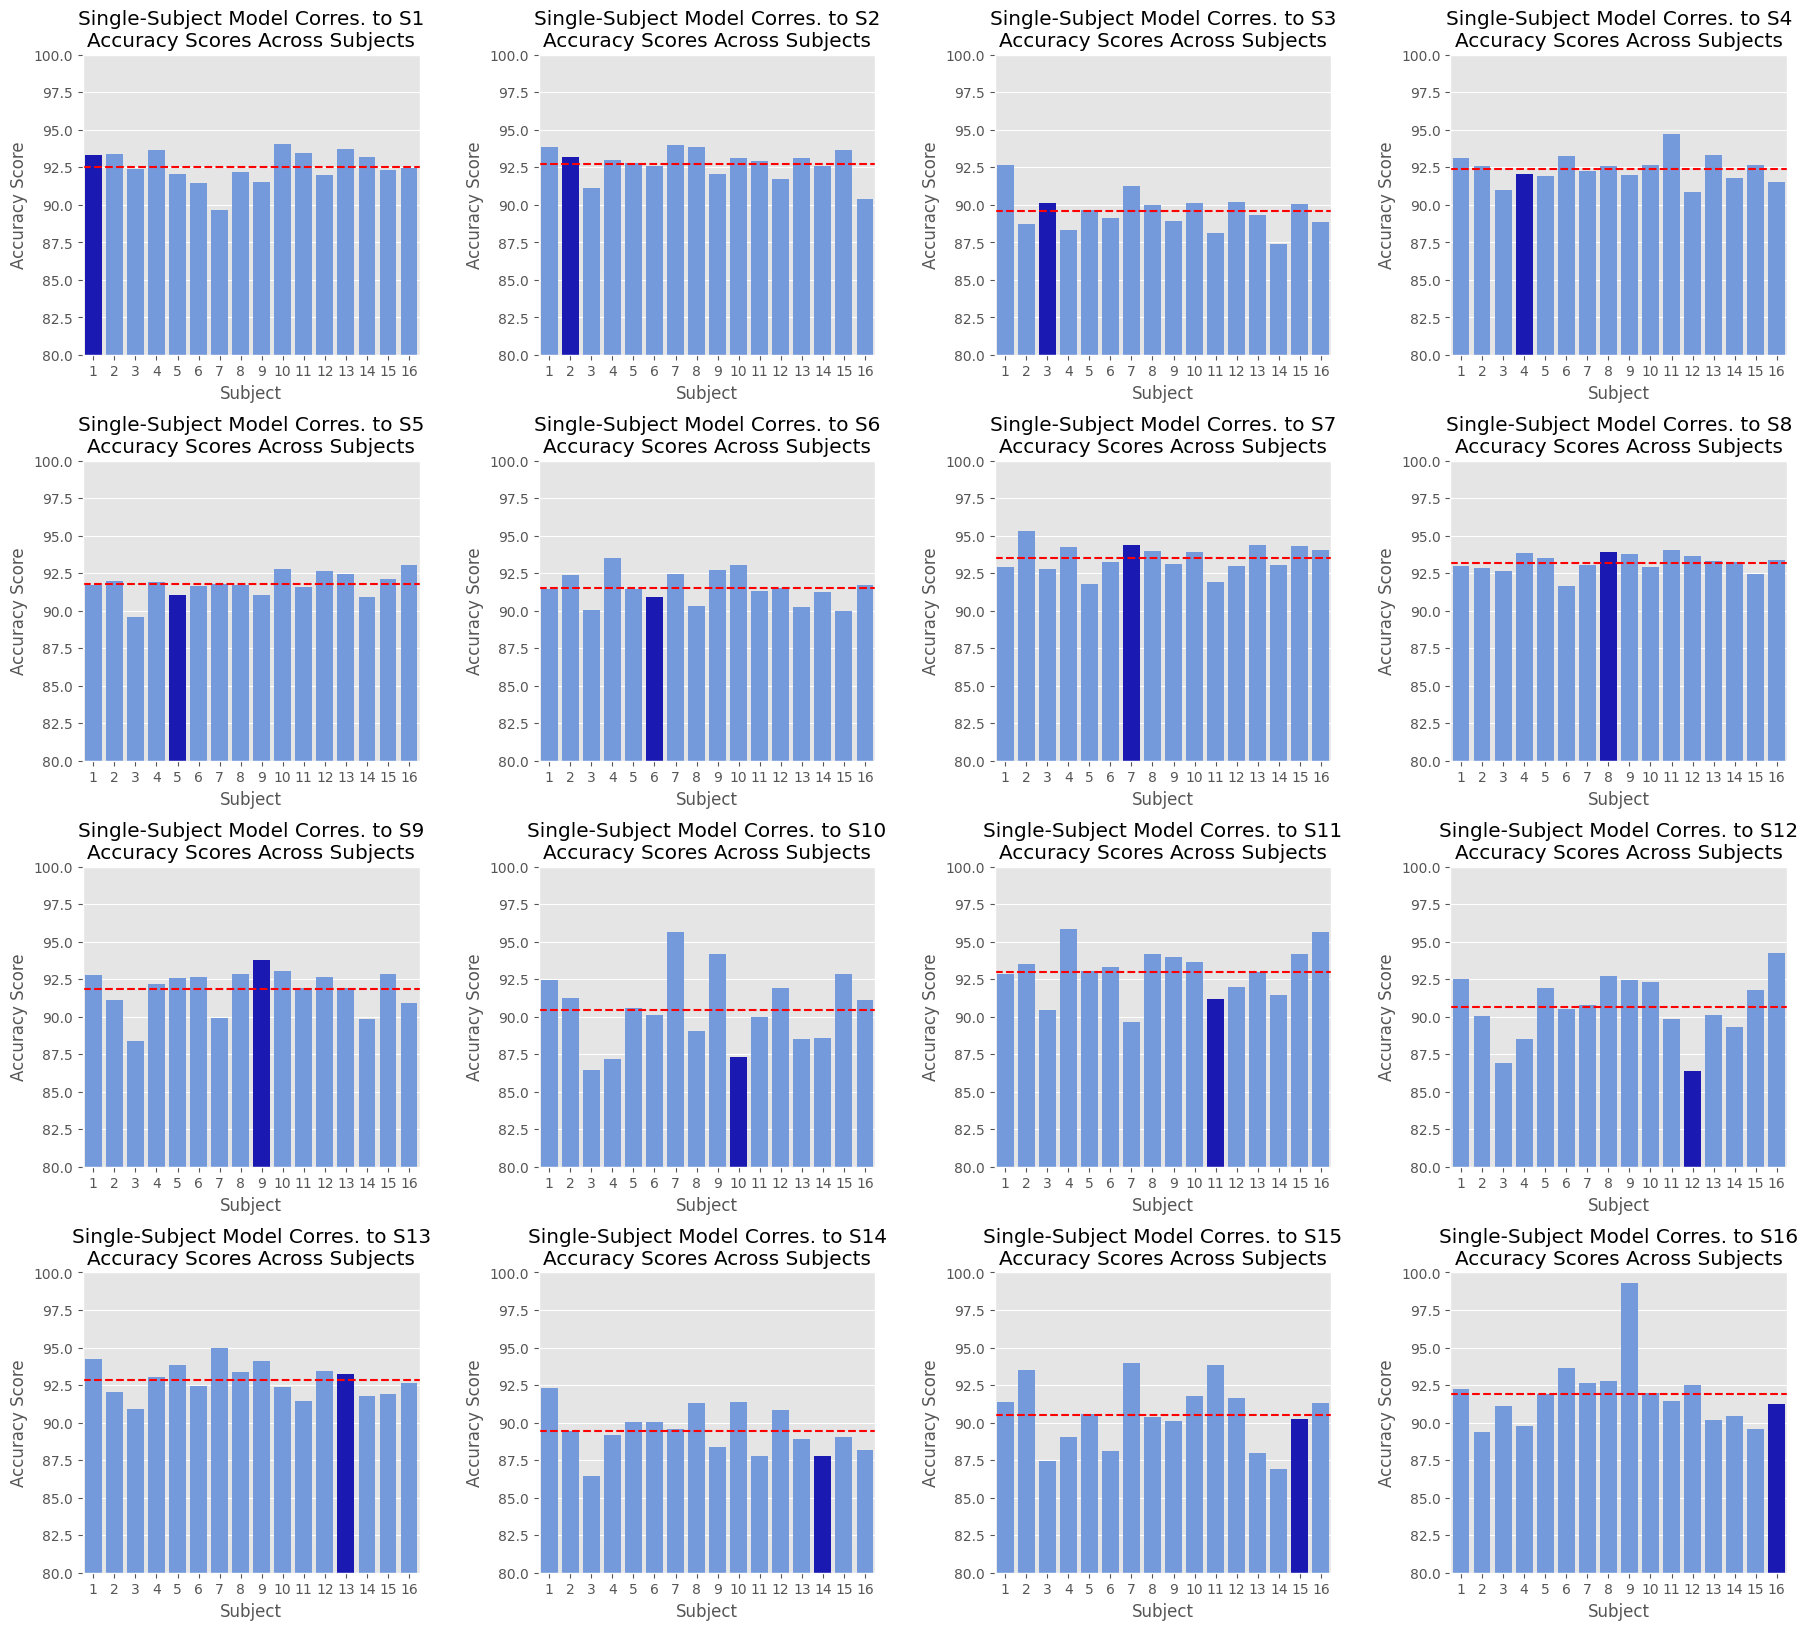

In [12]:
multiple_barplots(single_subject_models_results)

#### Discussing the Results

As we can see from the results above, our hypothesis is neither completely correct nor wrong. That is, it is very unlikely that a model which was trained on a subject, will perform best on it. However, it is quite likely (slightly more than 50%) that a model will perform better on the subject that it was trained on, than on some other subjects.

### Average-Subject Model Analysis

First, let us define the following term:

* We will define an “average-subject model” as a model which was trained on the average data across all subjects.

Now, we would like to see if an average-subject model performs more successfully on a subject, than its corresponding single-subject model.

Note that the average data contains some sort of information regarding each of the subjects (as the average across all subjects’ data). Thus, for each subject, when evaluating the average-subject model’s performance on it, we will perform CV on the data (the same data CV mentioned in the previous analysis). We are choosing to do so in order to avoid evaluating the model on data that it was somewhat trained on.


In [13]:
# auxiliary functions we will use in this part
def eval_avg_subject_model(subjects_data, vectors):

  avg_subject_data = np.mean(subjects_data, axis=0)
  avg_subject_resutls = cv_for_subject(avg_subject_data, subjects_data, vectors)

  return avg_subject_resutls


def mean_percentage_accuracy_improvment(avg_subject_model_results, self_models_results, model_name):

  s, c = 0, 0
  for avg_sujbect_res, self_res in zip(avg_subject_model_results, self_models_results):

    # only taking into account subjects that the average-subject model is better than the single-subject model
    if avg_sujbect_res <= self_res:
      s += (self_res - avg_sujbect_res) / self_res
      c += 1

  mean_percentage_accuracy_improvment = s/c * 100

  print(f"--- {model_name} compared to self-subject-model ---")
  print(f"Mean accuracy improvement: {mean_percentage_accuracy_improvment:.2f}%")


def double_barplot(avg_subject_model_results, self_models_results, model_name, color):

    x_indexes = np.arange(1, SUBJECTS_NUM+1)

    plt.figure(figsize=(8, 5))


    plt.bar(x_indexes + 0.125, avg_subject_model_results, width=0.25, color=color, label=f"{model_name.lower()}")
    plt.bar(x_indexes - 0.125, self_models_results, width=0.25, color="cornflowerblue", label="self-subject model")

    plt.title(f"{model_name} VS Self-Subject Model\nAccuracy Scores Acorss Subjects")
    plt.xlabel("Subject")
    plt.ylabel("Accurecy Score")

    plt.xticks(x_indexes)
    plt.ylim(75, 100)

    plt.legend()
    plt.show()

#### Results

First, we will obtain the results of the average-subject model across all subjects.

In [14]:
avg_subject_model_results = eval_avg_subject_model(subjects_data, vectors)

Moreover, we will find the results of the self-subject models on their corresponding subjects.

In [15]:
self_models_results = np.diag(np.array(single_subject_models_results))

Now, we will analyze the results.

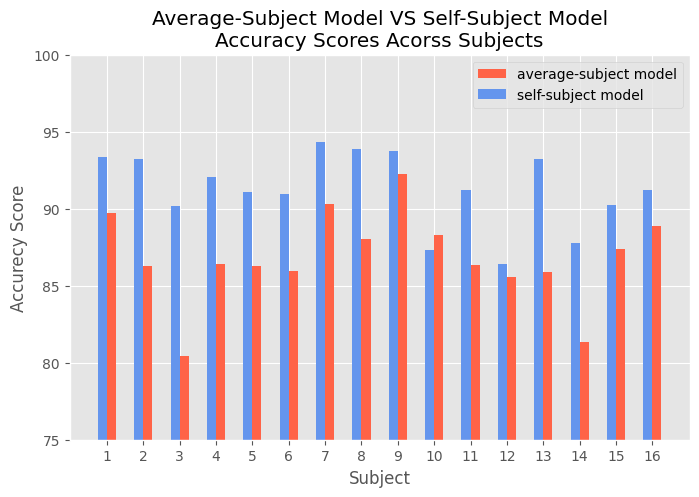

In [16]:
double_barplot(avg_subject_model_results, self_models_results, model_name="Average-Subject Model", color="tomato")

In [ ]:
mean_percentage_accuracy_improvment(avg_subject_model_results, self_models_results, model_name="average-subject model")

--- average-subject model compared to self-subject-model ---
Mean accuracy improvement: 5.22%


It appears that for 15 out of the 16 subjects, the average-subject model received a better (lower) accuracy score on them, than their corresponding single-subject models did (for the full comparison, see Fig8). The average accuracy score improvement across those 15 subjects is 5.22%. Although this improvement is not exceptional, it is also not negligible.

#### Discussing the Results

As previously mentioned, the average-subject model was somewhat trained on each of the subjects (by training on the average subjects’ data). Thus, when tested on a particular subject, it is reasonable to assume that the model will utilize the acquired training knowledge, which is associated with that subject. Moreover, the knowledge acquired on all other subjects may be seen as some sort of regularization, which enhances the model’s generalization abilities.

Thus, in the next analysis, we would like to see if the results still hold even when the average-subject model does not contain any sort of information regarding the subject that it is tested on.

### Average-Subject-Without Model Analysis

First, let us define the following terms:

* We will define a “average-subject-without model” as a model which was trained on the average data across all subjects except a particular subject.
* We will define that the average-subject-without model “corresponding” to subject i is a model that was trained on the average data of all subjects, except subject i.

Now, we would like to see if for a subject, its corresponding average-subject-without model performs more successfully on it, than its corresponding single-subject model does.

As mentioned above, and differently from the previous part, the training data of the average-subject-without model does not contain any sort of information regarding its corresponding subject. Thus, it is not required to perform CV in order to evaluate the model’s performance on that particular subject. However, we will still choose to perform CV to be able to better compare, for each subject, the performance of its corresponding average-subject-without model and single-subject model, as well as the average-subject model.


In [17]:
# auxiliary functions we will use in this part
def eval_avg_subject_model_without(subjects_data, vectors):

  res_lst = []

  for test_subject_num in range(SUBJECTS_NUM):
    subjects_data_without_test_subject = subjects_data.copy()
    test_subject_data = subjects_data_without_test_subject.pop(test_subject_num)

    # averaging all subjects data expect subject 'subject_num'
    avg_subject_data_without_test_subject = np.mean(subjects_data_without_test_subject, axis=0)

    res = cv_for_subject(avg_subject_data_without_test_subject, [test_subject_data], vectors)
    res_lst.append(res[0])

  return res_lst


def within_threshold(avg_subject_model_without_results, avg_subject_model_results, threshold):

  counter = 0

  for avg_subject_without_res, avg_subject_res in zip(avg_subject_model_without_results, avg_subject_model_results):

    if avg_subject_without_res - avg_subject_res <= threshold:
       counter += 1

  print("--- average-subject-without model compared to average-subject model ---")
  print(f"the accuracy score of '{counter}' out of 16 subjects is bigger (worst) by at most '{threshold}'")

#### Results

First, we will obtain the results of the average-subject-without model on the corresponding subjects.

In [18]:
avg_subject_model_without_results = eval_avg_subject_model_without(subjects_data, vectors)

Now, we will analyze the results.

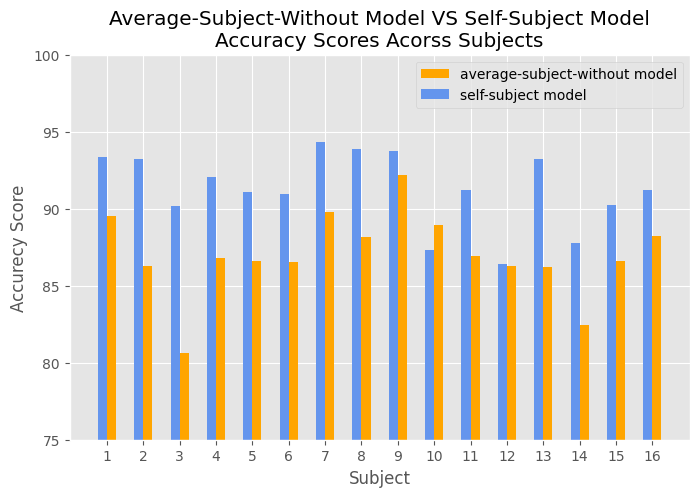

In [19]:
double_barplot(avg_subject_model_without_results, self_models_results, model_name="Average-Subject-Without Model", color="orange")

In [20]:
mean_percentage_accuracy_improvment(avg_subject_model_without_results, self_models_results, model_name="average-subject-without model")

--- average-subject-without model compared to self-subject-model ---
Mean accuracy improvement: 5.06%


In [21]:
within_threshold(avg_subject_model_without_results, avg_subject_model_results, threshold=1.1)

--- average-subject-without model compared to average-subject model ---
the accuracy score of '16' out of 16 subjects is bigger (worst) by at most '1.1'


It appears that also in this case, for 15 out of the 16 subjects, their corresponding average-subject-without models performed better on them, than their corresponding single-subject models. The average accuracy score improvement across those 15 subjects is 5.06%. Although this improvement is not exceptional, it is also not negligible. Regarding the average-subject model, first note that the improvement result of both models is almost identical (5.06% compared to 5.22%). Moreover, for each subject, the corresponding average-subject-without model’s accuracy score is higher (worse) than the average-subject model by 1.1 at most. Hence, it seems that both models’ performance is relatively similar.

#### Discussing the Results

As mentioned in the previous part, the average-subject model containes some sort of information regarding each subject. However, in this case, for each subject, its corresponding average-subject-without model was not trained on that subject’s data at all (by the definition of the model). This substantial difference makes the results of this analysis much more impressive, especially since both models’ performance is approximately the same. Moreover, these results indicate that a model which was trained on a group of random people, can better predict the concept that a person was exposed to, than a model which was trained on his own brain data.

Furthermore, these results might suggest the possibility of creating a universal brain decoder model. That is, we can take a large group of random people, train a model on the average brain data of that group, and gain such model. This model will allow us to take a random person and predict the concept that they were exposed to, without the need to fit a model for that person specifically, and even gain greater predictive power.


## Brain Encoder Analysis

### Inter-Subject Correlation Analysis

In this analysis, we will check for correlation between the degree to which an ROI is mutually active among different subjects (when stimulated with a concept), and the importance of that ROI during concept processing.


In [ ]:
# constants
ROIS_NUM = 116

# auxiliary functions we will use in this part
def calc_rois_intersubject_correlation(subjects_data):

  subjects_rois_corr = []

  for subject_num in range(SUBJECTS_NUM):

    subjects_data_without = subjects_data.copy()
    subject_data = subjects_data_without.pop(subject_num)
    # averaging all subjects data expect subject 'subject_num'
    avg_subject_data_without = np.mean(subjects_data_without, axis=0)

    subject_rois_corr = []

    for roi_num in range(ROIS_NUM):

      roi_corr, _ = scipy.stats.pearsonr(subject_data[:, roi_num], avg_subject_data_without[:, roi_num])
      subject_rois_corr.append(roi_corr)

    subjects_rois_corr.append(subject_rois_corr)

  intersubject_rois_correlation = np.mean(subjects_rois_corr, axis=0)
  return intersubject_rois_correlation


def scatter_plot(x, y, m, b):

  plt.scatter(x, y, color="royalblue")

  plt.title("Scatter Plot of (ROI ISC, ROI R^2) Points")
  plt.xlabel("ISC")
  plt.ylabel("R^2")

  #add the linear regression line to scatterplot
  plt.plot(x, m*x+b, color="tomato", label="regression line")

  plt.legend()
  plt.show()

#### First Tested Measure

In order to measure to what degree an ROI is mutually active among the different subjects, we will perform Inter-Subject Correlation (ISC): for each ROI, and for a given subject, we will calculate the correlation (using Pearson correlation) between that subject’s ROI data and the average ROI data of all other subjects. As a result, for each ROI we will receive 16 correlation scores (one for each subject). Finally, to get the overall correlation score for each ROI, we will average the 16 scores mentioned above

This process is implemented below by the "calc_rois_intersubject_correlation" function.

In [ ]:
rois_intersubject_correlation = calc_rois_intersubject_correlation(subjects_data)

#### Second Tested Measure

In order to measure the importance of an ROI during concept processing, we fit a linear regression model for each of the ROIs, and calculated their R^2 value (as done in Section 2 of the Semi-structured Task, except for ROIs fMRI data instead of voxels).

Recall that the GloVe model embeds words into a 300-dimensional vector space, while we only have 180 concepts in experiment 1. Thus, we have more explaining variables than samples in our linear regression models. To overcome that, we performed dimensionality reduction (using PCA) and reduced the embedded vectors to 150 dimensions.

Note, that the data from experiment 2 contains 384 examples (sentences), which is strictly greater than 300. Thus, we could overcome the mentioned problem and avoid performing PCA (which results in information loss), by using the data from experiment 2. However, only 6 subjects participated in it. In brain data analysis, it is well-known that the number of participants is crucial, due to low signal-to-noise ratio. Therefore, using the data from experiment 2 would have a drastically negative affect on the ISC results. Thus, we chose to keep using the data from experiment 1 (and perform PCA).


In [ ]:
# getting the average subject data
avg_subject_data = np.mean(subjects_data, axis=0)

# performing the dimensionality reduction to 150 dimensionas using PCA
pca_to150 = PCA(n_components=150, svd_solver="full")
GloVe_150d_vectors = pca_to150.fit_transform(vectors)

# getting the R^2 values
rois_R_squared, _ = voxels_linear_reg(GloVe_150d_vectors, avg_subject_data)

#### Results

Now, after obtaining both tested measures, will analyze the resutls by performing linear regression to receive the correlation between them, and the statistical significance.

In [ ]:
m, b, r, p_value, se = scipy.stats.linregress(rois_intersubject_correlation, rois_R_squared)

print(f"ROIs ISC and R^2 linear correlation value: {r:.3f}")
print(f"p_value: {p_value:0.2e}")

ROIs ISC and R^2 linear correlation value: 0.540
p_value: 3.89e-10


#### Discussing the Results

As we can see, it is statistically significant that there is quite a high positive correlation between the tested measures. In other words, the more an ROI is mutually active among different subjects, the higher the importance of that ROI during concept processing.

For visualization purposes, we created a scatter plot (with a linear regression line) where each ROI is represented by a point of form (ISC, R^2).

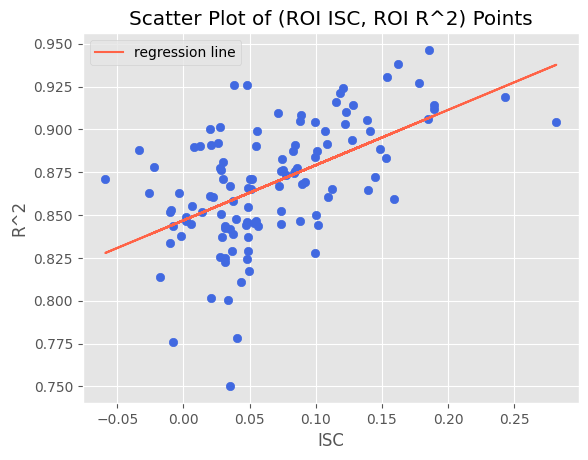

In [ ]:
scatter_plot(rois_intersubject_correlation, rois_R_squared, m, b)